In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class Mixture:

    def __init__(self, r, gaussians):
        self.r = r
        self.gaussians = gaussians  # (mu_0,sigma_0), (mu_1,sigma_1).

    def generate_data(self, n_samples=1000):
        r = torch.full([n_samples], self.r)
        z = torch.bernoulli(r)
        x = torch.empty(n_samples)
        x[z == 0] = torch.normal(*self.gaussians[0], [(z == 0).sum()])
        x[z == 1] = torch.normal(*self.gaussians[1], [(z == 1).sum()])
        return x
    
    @staticmethod
    def p_x(x, r, gaussians):
        mu = gaussians[0][0], gaussians[1][0]
        var = gaussians[0][1]**2, gaussians[1][1]**2

        p0 = (2*torch.pi*var[0])**(-1/2) * torch.exp(-1/(2*var[0]) * (x-mu[0])**2)
        p1 = (2*torch.pi*var[1])**(-1/2) * torch.exp(-1/(2*var[1]) * (x-mu[1])**2)
        p = (1 - r) * p0 + r * p1
        return p

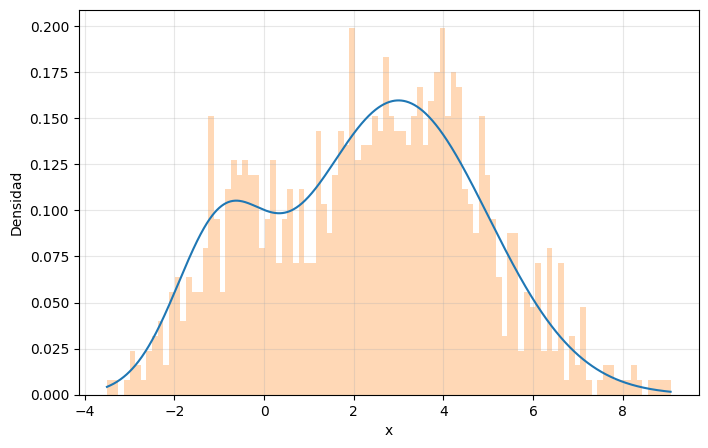

In [3]:
r = 0.8
gaussians = [(-1, 1), (3, 2)]

# Datos:
dataset = Mixture(r, gaussians)
x = dataset.generate_data()


# Gráfico:
x_plot = torch.linspace(min(x), max(x), 1000)
density = Mixture.p_x(x_plot, r, gaussians)

plt.figure(figsize=(8, 5))
plt.plot(x_plot, density)
plt.hist(x, bins=100, density=True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('Densidad')
plt.grid(alpha=0.3)
plt.show()

In [4]:
class PriorEstimator(nn.Module):

    def __init__(self, init_val=0.5):
        super().__init__()
        self.logit_r = nn.Parameter(torch.tensor(init_val))
    
    def forward(self):
        return torch.sigmoid(self.logit_r)

In [5]:
def train_loop(model, optimizer, x, n_epochs=500):
    
    normalized_nlls, r_preds = [], []

    for epoch in range(n_epochs):
        r_pred = model()
        p_x = Mixture.p_x(x, r_pred, gaussians)
        normalized_nll = - p_x.log().mean()  # debería ser sum!
        
        optimizer.zero_grad()
        normalized_nll.backward()
        optimizer.step()
        
        normalized_nlls.append(normalized_nll.item())
        r_preds.append(r_pred.item())
    
    return normalized_nlls, r_preds

In [6]:
model = PriorEstimator()
optimizer = optim.SGD(model.parameters(), lr=1)

train_loop(model, optimizer, x)

print(f'Estimación: {model().item():.4f}')
print(f'Valor real: {dataset.r}')

Estimación: 0.8162
Valor real: 0.8


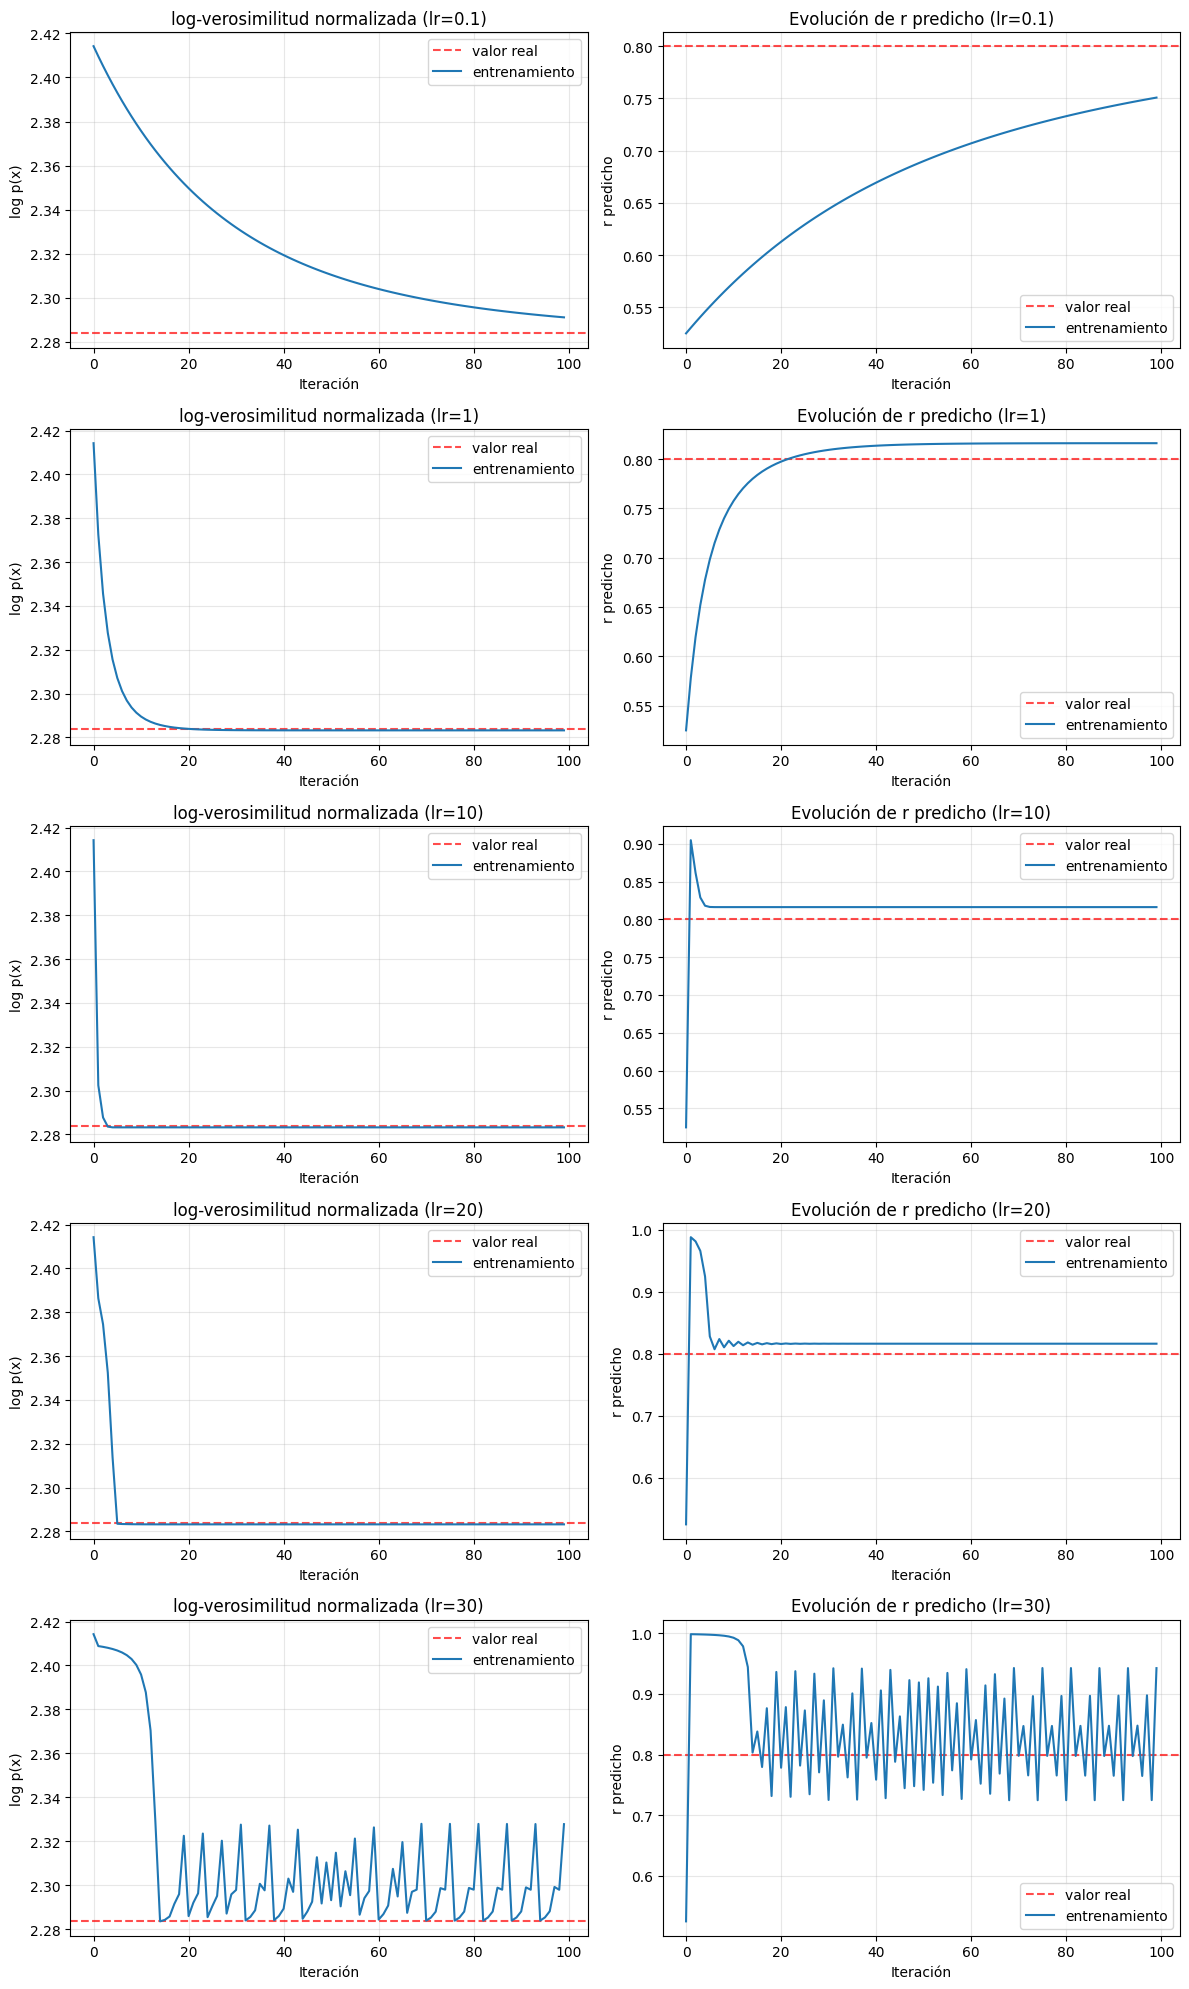

In [7]:
learning_rates = [0.1, 1, 10, 20, 30]
n_rows = len(learning_rates)

fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))

for i, lr in enumerate(learning_rates):

    # Entrenamiento:
    model = PriorEstimator(init_val=0.1)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    normalized_nlls, r_preds = train_loop(model, optimizer, x, n_epochs=100)

    # Función de pérdida (NLL normalizado):
    p_x = Mixture.p_x(x, r, gaussians)
    normalized_nll = - p_x.log().mean()
    
    # Gráfico loss:
    axes[i, 0].axhline(y=normalized_nll, linestyle='--', color='r', alpha=0.7, label='valor real')
    axes[i, 0].plot(normalized_nlls, label='entrenamiento')
    axes[i, 0].set_xlabel('Iteración')
    axes[i, 0].set_ylabel('log p(x)')
    axes[i, 0].grid(alpha=0.3)
    axes[i, 0].set_title(f'log-verosimilitud normalizada (lr={lr})')
    axes[i, 0].legend()

    # Gráfico r:
    axes[i, 1].axhline(y=r, linestyle='--', color='r', alpha=0.7,label='valor real')
    axes[i, 1].plot(r_preds, label='entrenamiento')
    axes[i, 1].set_xlabel('Iteración')
    axes[i, 1].set_ylabel('r predicho')
    axes[i, 1].grid(alpha=0.3)
    axes[i, 1].set_title(f'Evolución de r predicho (lr={lr})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()